# **LIBRARY PREPARATION**

In [13]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# **DXG DATA PREPARATION**

In [14]:
# 7:3 ratio
df = pd.read_csv('DXG Historical Data 2018.csv') # Read data
df = df[['Price']]
df = df.dropna() # Drop NaN values
df = df[::-1] #Chronological order

df = df.reset_index(drop=True) # Reset the index

In [15]:
# Remove commas and convert to numeric in 'Price'
df['Price'] = df['Price'].str.replace(',', '').astype(float)

df

,Price
0,13401.4
1,13371.1
2,13522.4
3,13159.4
4,14066.9
...,...
1547,19000.0
1548,18500.0
1549,18750.0
1550,19500.0


# **Stationary Test using ADF Test**

In [16]:
# ADF Test Function
def adf_test(series,title=''):
    """ Input a time series and an optional title to return an ADF report """

    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF Test Statistic','p-value','# Lags used','# Observations']
    out = pd.Series(result[0:4],index = labels)

    for key,val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis,\nReject the null hypothesi,\n --> Data has no unit root and is STATIONARY")
    else:
        print("\nWeak evidence against the null hypothesis,\nFail to reject the null hypothesis,\n --> nData has a unit root and is NON-STATIONARY")

In [17]:
adf_test(df['Price'], 'Stationarity')

Augmented Dickey-Fuller Test: Stationarity
ADF Test Statistic        -2.382780
p-value                    0.146656
# Lags used               20.000000
# Observations          1531.000000
Critical Value (1%)       -3.434628
Critical Value (5%)       -2.863430
Critical Value (10%)      -2.567776

Weak evidence against the null hypothesis,
Fail to reject the null hypothesis,
 --> nData has a unit root and is NON-STATIONARY


# **CONVERT TO STATIONARY TIME SERIES**

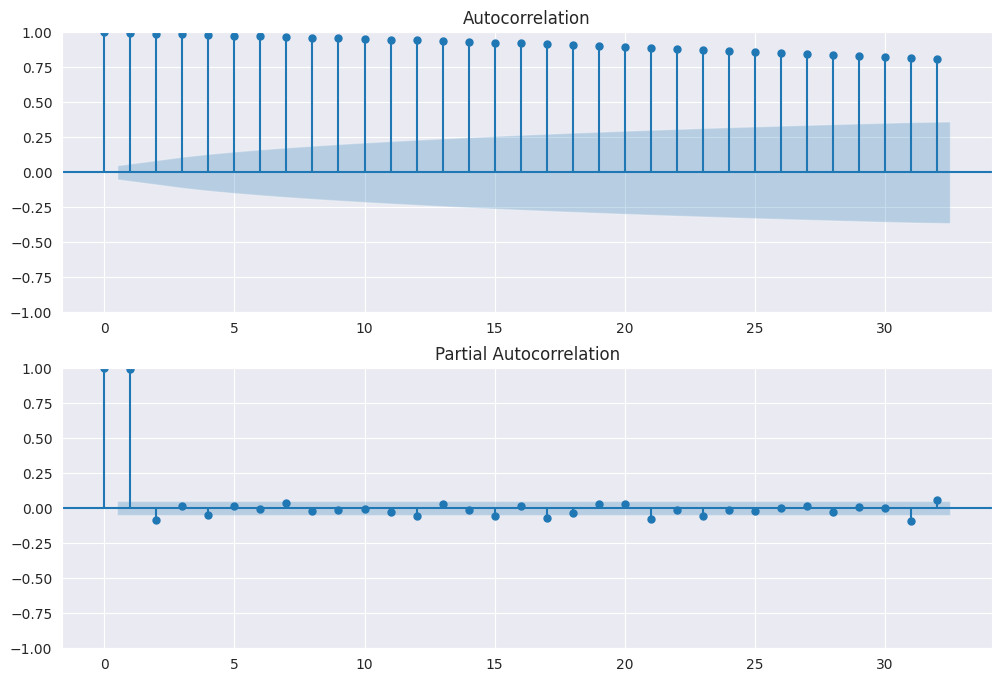

In [18]:
# Plotting the AutoCorrelation Function and Partial AutoCorrelation Function to determine ARIMA parameters.
fig, axes = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df['Price'], ax=axes[0])
plot_pacf(df['Price'], ax=axes[1])
plt.show()

In [19]:
log_price = np.log(df['Price'])
log_diff = log_price.diff().dropna()

In [20]:
adf_test(log_diff, 'Stationarity')

Augmented Dickey-Fuller Test: Stationarity
ADF Test Statistic       -35.715968
p-value                    0.000000
# Lags used                0.000000
# Observations          1550.000000
Critical Value (1%)       -3.434576
Critical Value (5%)       -2.863406
Critical Value (10%)      -2.567764

Strong evidence against the null hypothesis,
Reject the null hypothesi,
 --> Data has no unit root and is STATIONARY


# **TRAIN-TEST SPLIT**

In [21]:
# Split the data into training and testing sets
train_size = int(0.7 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

# **TRAINING PROCESSS**

In [22]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, start_p=1, start_q=1,
                   max_p=5, max_q=5, stationary=False,
                   start_P=0, seasonal=False,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit an ARIMA model to the training data
model = ARIMA(train_data, order=(1, 1, 2))
model_fit = model.fit()

# Forecast the test_data
forecast = model_fit.forecast(steps=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17076.989, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17087.189, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17082.073, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17081.462, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17085.603, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17078.559, Time=2.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17078.610, Time=3.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17081.618, Time=0.90 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17082.427, Time=0.71 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17080.239, Time=2.87 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17075.292, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17079.787, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17080.398, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=17076.835, Time=0.85 sec
 ARIMA(1,1,2)(0,0,0

# **PREDICTION**

In [23]:
### 1. Create sequence index
last_index =  df.index[-1]

# a) For 30 Days
last_data_30 = pd.RangeIndex(start = last_index, stop = last_index + 30, step = 1)

# b) For 60 Days
last_data_60 = pd.RangeIndex(start = last_index, stop = last_index + 60, step = 1)

# c) For 90 Days
last_data_90 = pd.RangeIndex(start = last_index, stop = last_index + 90, step = 1)


### 2. Create array

# a) Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

# b) Create an array of 60 consecutive integers starting from last_index
x_next_60_days = np.array(range(last_index + 1, last_index + 61)).reshape(-1, 1)

# c) Create an array of 90 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index + 1, last_index + 91)).reshape(-1, 1)


### 3. Predict closing prices

# a) Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days))

# a) Predict the closing prices for the next 60 days
y_next_60_days = model_fit.forecast(steps=len(x_next_60_days))

# a) Predict the closing prices for the next 90 days
y_next_90_days = model_fit.forecast(steps=len(x_next_90_days))


### 4. Print result

# a) Print the predicted closing prices for the next 30 days
print('Predicted Closing Prices for the next 30 days:')
print(y_next_30_days)

# b) Print the predicted closing prices for the next 60 days
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days[30:60])

# c) Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days[60:90])

Predicted Closing Prices for the next 30 days:
1086    26836.830099
1087    26802.877770
1088    26829.743256
1089    26808.485382
1090    26825.306117
1091    26811.996360
1092    26822.527982
1093    26814.194617
1094    26820.788565
1095    26815.570967
1096    26819.699500
1097    26816.432712
1098    26819.017626
1099    26816.972259
1100    26818.590698
1101    26817.310075
1102    26818.323395
1103    26817.521584
1104    26818.156034
1105    26817.654012
1106    26818.051247
1107    26817.736927
1108    26817.985639
1109    26817.788840
1110    26817.944562
1111    26817.821344
1112    26817.918842
1113    26817.841695
1114    26817.902739
1115    26817.854437
Name: predicted_mean, dtype: float64
Predicted closing prices for the next 60 days:
1116    26817.892657
1117    26817.862414
1118    26817.886345
1119    26817.867409
1120    26817.882392
1121    26817.870537
1122    26817.879918
1123    26817.872495
1124    26817.878368
1125    26817.873721
1126    26817.877398
1127    

# **EVALUATION**

In [24]:
# Calculate performance metrics
test_mae = mean_absolute_error(test_data, forecast)
test_mape = mean_absolute_percentage_error(test_data, forecast)
test_rmse = sqrt(mean_squared_error(test_data, forecast))
test_mse = mean_squared_error(test_data, forecast)

# Calculate Mean Absolute Scaled Error (MASE)
naive_forecast = train_data.shift(1).dropna()
mase_denom = mean_absolute_error(train_data[1:], naive_forecast)
test_mase = test_mae / mase_denom

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)
print('MSE:', test_mse)
print('MASE:', test_mase)

MAE: 9210.152136619088
RMSE: 10233.208461696699
MAPE: 0.6289629373037888
MSE: 104718555.42054091
MASE: 22.119294530439294


# **VISUALIZATION**

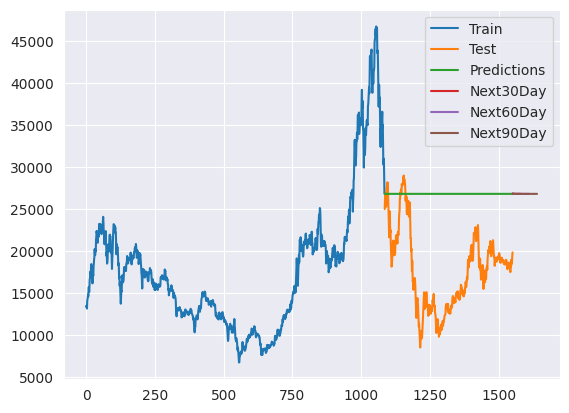

In [25]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, forecast)
plt.plot(last_data_30, y_next_30_days)
plt.plot(last_data_60, y_next_60_days)
plt.plot(last_data_90, y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

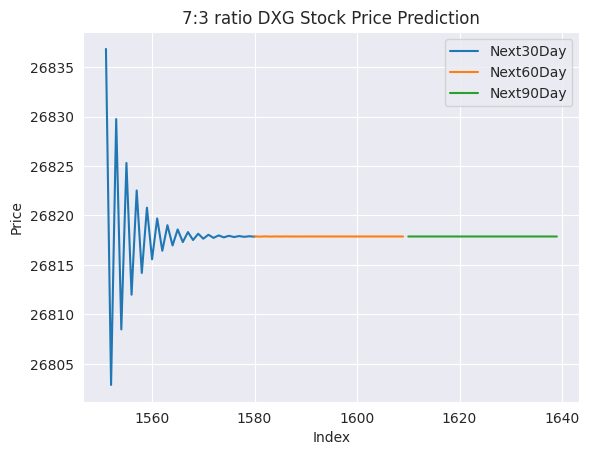

In [27]:
plt.plot(last_data_30, y_next_30_days)
plt.plot(range(last_data_30[-1], last_data_60[-1]), y_next_60_days[30:])
plt.plot(range(last_data_60[-1], last_data_90[-1]), y_next_90_days[60:])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('7:3 ratio DXG Stock Price Prediction')
plt.legend(['Next30Day', 'Next60Day', 'Next90Day'])

plt.show()